In [27]:
import os
os.environ['OPENAI_API_KEY'] = 'sk-proj-gECJbZO1y4sk3NoUB1SbT3BlbkFJ5QdYttqNjmS1hSsGQIJY'
from openai import OpenAI
import json
from tqdm.auto import tqdm
import base64
import requests
import torch
import re
import tiktoken
import pandas as pd
import io
from PIL import Image

## check #tokens

In [33]:
batch_body = """
{{
  "custom_id":"{custom_id}",
  "method":"POST",
  "url":"/v1/chat/completions",
  "body": {payload}
}}
"""
batch_body = re.sub("\s\s+" , " ", batch_body.replace("\n", ""))
payload = """
{{
  "model": "gpt-4o",
  "messages": [
    {{
      "role": "user",
      "content": [
        {{
          "type": "text",
          "text": "{prompt}"
        }},
        {{
          "type": "image_url",
          "image_url": {{
            "url": "data:image/jpeg;base64,{base64_image}"
          }}
        }}
      ]
    }}
  ],
  "max_tokens": 3000
}}
"""

payload =  re.sub("\s\s+" , " ", payload.replace("\n", ""))


prompt = """
Answer the following questions using the given image. List the objects' names for the 1st and 2nd questions in the 1st and 2nd lines (separated by commas) without explanations. Each object should be fully visible after editing and not already included in the original image.

1. Suggest 5 objects that can be edited into this image and placed in only one location
2. Suggest 5 objects that can be edited into this image and placed in multiple locations, but not just anywhere

Answer 'None' if it is implausible to insert any objects.
"""
prompt =  re.sub("\s\s+" , " ", prompt.replace("\n", "\\n"))
prompt

"\\nAnswer the following questions using the given image. List the objects' names for the 1st and 2nd questions in the 1st and 2nd lines (separated by commas) without explanations. Each object should be fully visible after editing and not already included in the original image.\\n\\n1. Suggest 5 objects that can be edited into this image and placed in only one location\\n2. Suggest 5 objects that can be edited into this image and placed in multiple locations, but not just anywhere\\n\\nAnswer 'None' if it is implausible to insert any objects.\\n"

In [34]:
enc = tiktoken.encoding_for_model("gpt-4o")
tokens = enc.encode(prompt)
len(tokens)

124

## prepare test data

In [35]:
df = pd.read_csv("./dataset/rev1/small_dataset.csv")
df.head(2)

,id,source,img_path,has_subject,is_abstract,is_birdeye_view,is_closeup_shot,is_macro_shot,looking_sky
0,1010,Flickr2K,./data_preprocessed/Flickr2K/000911.png,True,False,False,False,False,False
1,729,Flickr2K,./data_preprocessed/Flickr2K/000630.png,True,False,False,True,False,False


In [36]:
def encode_image(image_path):
    with Image.open(image_path) as img:
        img = img.resize((512, 512))
        
        buffered = io.BytesIO()
        img.save(buffered, format="JPEG")
        encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        return encoded_string

def prepare_data(df, start=None, end=None):
    image_paths = df["img_path"].to_numpy()
    output = []
    for idx, path in tqdm(enumerate(image_paths), total=len(image_paths)):
        base64_image = encode_image(path)
        current_payload = payload.format(prompt=prompt, base64_image=base64_image)
        output += [batch_body.format(custom_id=idx, payload=current_payload)]

    if (start is None) or (end is None):
        return output
    else:
        return output[start:end]

In [37]:
output = prepare_data(df, start=0, end=5)
input_file_path = "./dataset/rev1/small_dataset_first5.jsonl"
with open(input_file_path, 'w', encoding='utf-8') as f:
    for line in output:
        f.write(line+'\n')

output[0][:1000]

  0%|          | 0/140 [00:00<?, ?it/s]

'{ "custom_id":"0", "method":"POST", "url":"/v1/chat/completions", "body": { "model": "gpt-4o", "messages": [ { "role": "user", "content": [ { "type": "text", "text": "\\nAnswer the following questions using the given image. List the objects\' names for the 1st and 2nd questions in the 1st and 2nd lines (separated by commas) without explanations. Each object should be fully visible after editing and not already included in the original image.\\n\\n1. Suggest 5 objects that can be edited into this image and placed in only one location\\n2. Suggest 5 objects that can be edited into this image and placed in multiple locations, but not just anywhere\\n\\nAnswer \'None\' if it is implausible to insert any objects.\\n" }, { "type": "image_url", "image_url": { "url": "'

## infer test data

In [38]:
client = OpenAI()

In [40]:
batch_input_file = client.files.create(
  file=open(input_file_path, "rb"),
  purpose="batch"
)

In [41]:
batch_input_file

FileObject(id='file-ImAO6de74eZ7yDohsY7YwZP6', bytes=379302, created_at=1721627993, filename='small_dataset_first5.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [42]:
# file-ImAO6de74eZ7yDohsY7YwZP6
batch_input_file_id = batch_input_file.id
batch_input_file_id

'file-ImAO6de74eZ7yDohsY7YwZP6'

In [43]:
client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
      "description": "collocation_small_dataset_test"
    }
)

Batch(id='batch_61spBeW7npkLCvqoRxlrZcUj', completion_window='24h', created_at=1721628078, endpoint='/v1/chat/completions', input_file_id='file-ImAO6de74eZ7yDohsY7YwZP6', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1721714478, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'collocation_small_dataset_test'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [ ]:
# batch_61spBeW7npkLCvqoRxlrZcUj

In [52]:
client.batches.retrieve('batch_61spBeW7npkLCvqoRxlrZcUj')

Batch(id='batch_61spBeW7npkLCvqoRxlrZcUj', completion_window='24h', created_at=1721628078, endpoint='/v1/chat/completions', input_file_id='file-ImAO6de74eZ7yDohsY7YwZP6', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1721628142, error_file_id=None, errors=None, expired_at=None, expires_at=1721714478, failed_at=None, finalizing_at=1721628141, in_progress_at=1721628078, metadata={'description': 'collocation_small_dataset_test'}, output_file_id='file-uE8bUWkeN7PHgu4dypYiGqHa', request_counts=BatchRequestCounts(completed=5, failed=0, total=5))

In [59]:
content = client.files.content("file-uE8bUWkeN7PHgu4dypYiGqHa")

In [62]:
output_file_path = "dataset/rev1/output_small_dataset_first5.jsonl"

with open(output_file_path, 'w') as f:
    f.write(content.content.decode("utf-8"))

In [63]:
o = [json.loads(i) for i in open(output_file_path).readlines()]

In [64]:
o[0]

{'id': 'batch_req_3yOpXbxzfwmlQOXhFAmek15F',
 'custom_id': '0',
 'response': {'status_code': 200,
  'request_id': '28241275a66776c0c6b1767d74f5ff5b',
  'body': {'id': 'chatcmpl-9ngOoNEsO0VtE0wcp5ggQ5Nw4h8Ys',
   'object': 'chat.completion',
   'created': 1721628082,
   'model': 'gpt-4o-2024-05-13',
   'choices': [{'index': 0,
     'message': {'role': 'assistant',
      'content': '1. Plant pot, Bicycle, Patio chair, Lantern, Mailbox\n2. Flower bed, Garden gnome, Wind chime, Solar light, Patio table'},
     'logprobs': None,
     'finish_reason': 'stop'}],
   'usage': {'prompt_tokens': 382,
    'completion_tokens': 33,
    'total_tokens': 415},
   'system_fingerprint': 'fp_18cc0f1fa0'}},
 'error': None}

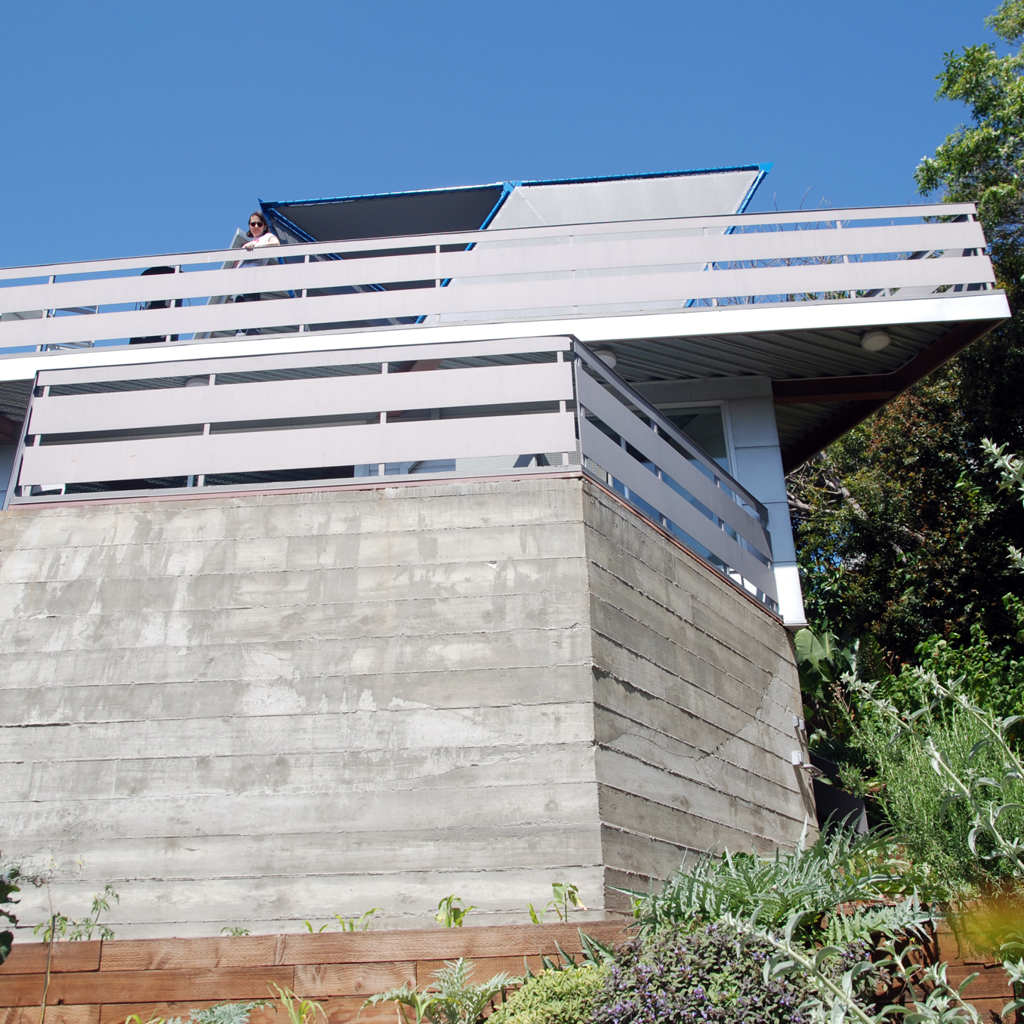

In [66]:
Image.open("./data_preprocessed/Flickr2K/000911.png")